# Bitcoin Prediction

In [448]:
# Load the stuff..
# Sorry if you see # type: ignore, it's due to me using a type checking linter for other projects
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

## Load Data

In [449]:
# Load the files from data folder. -- Normally would write this differently 
# but didn't realize jupyter notebooks don't have __file__ attribute

output_dir = "../output"
data_directory = "../data"


def load_data(data_directory):

    csv_file = pathlib.Path(data_directory, "pricedBitcoin2009-2018.csv")
    amo_chainlets_file = pathlib.Path(data_directory, "AmoChainletsInTime.txt")
    occ_chainlets_file = pathlib.Path(data_directory, "OccChainletsInTime.txt")

    price_df = pd.read_csv(csv_file)

    # Load chainlet data
    amo_chainlets = pd.read_csv(amo_chainlets_file, sep="\t")
    occ_chainlets = pd.read_csv(occ_chainlets_file, sep="\t")

    amo_chainlets.columns = amo_chainlets.columns.str.strip()
    occ_chainlets.columns = occ_chainlets.columns.str.strip()

    return price_df, amo_chainlets, occ_chainlets


def find_significant_patterns(amo_chainlets, occ_chainlets, start_year=2009, top_n=10):
    # Filter data for the relevant time period
    recent_occ = occ_chainlets[occ_chainlets["year"] >= start_year]
    recent_amo = amo_chainlets[amo_chainlets["year"] >= start_year]

    # Get chainlet pattern columns 
    chainlet_cols = [col for col in recent_occ.columns if ":" in col]

    # Calculate total occurrences for each pattern
    pattern_frequency = recent_occ[chainlet_cols].sum()

    # Calculate total amounts for each pattern
    pattern_amounts = recent_amo[chainlet_cols].sum()

    # Calculate average value per transaction for each pattern
    avg_value_per_pattern = pattern_amounts / pattern_frequency
    avg_value_per_pattern = avg_value_per_pattern.replace(
        [np.inf, -np.inf], np.nan
    ).fillna(0)

    # Normalize both metrics
    freq_normalized = (pattern_frequency - pattern_frequency.min()) / (
        pattern_frequency.max() - pattern_frequency.min()
    )
    value_normalized = (avg_value_per_pattern - avg_value_per_pattern.min()) / (
        avg_value_per_pattern.max() - avg_value_per_pattern.min()
    )

    # Combine both metrics into a single score for each chainlet
    pattern_importance = freq_normalized + value_normalized

    # Get top_n most significant patterns
    top_patterns = pattern_importance.nlargest(top_n)

    # This library is something I like using for cli tables when 
    # I have to write stuff in python.
    table = PrettyTable()
    table.field_names = ["Pattern", "Frequency", "Avg Value (satoshis)", "Combined Score"]
    
    for pattern in top_patterns.index:
        table.add_row([
            pattern, 
            f"{pattern_frequency[pattern]:,}",  
            f"{avg_value_per_pattern[pattern]:,.0f}",
            f"{pattern_importance[pattern]:.4f}"
        ])
    
    table.align = "r"  
    table.align["Pattern"] = "l"  # type: ignore

    print("\nMost significant chainlet patterns:")
    print(table)

    return top_patterns.index.tolist()


In [450]:
price_df, amo_chainlets, occ_chainlets = load_data(data_directory=data_directory)

# Add month column for splitting December data
price_df["month"] = pd.to_datetime(price_df["date"]).dt.month

## Prepare Data

In [451]:
def prepare_features(price_df, amo_chainlets, occ_chainlets, start_year=2009):
    # Filter data from start_year argument
    price_df = price_df[price_df["year"] >= start_year].copy()
    
    amo_chainlets = amo_chainlets.reindex(price_df.index)
    occ_chainlets = occ_chainlets.reindex(price_df.index)

    # Create lag features for price (last 7 days)
    for i in range(1, 8):
        price_df[f"price_lag_{i}"] = price_df["price"].shift(i)

 
    significant_patterns = find_significant_patterns(amo_chainlets, occ_chainlets)

    # Add chainlet features from the significant patterns derived earlier
    for pattern in significant_patterns:
        price_df[f"amo_{pattern}"] = amo_chainlets[pattern].values
        price_df[f"occ_{pattern}"] = occ_chainlets[pattern].values

    # Drop rows with NaN values
    price_df = price_df.dropna()

    return price_df


def split_data(df):
    # Test Dataset (December 2017)
    test_data = df[(df["year"] == 2017) & (df["month"] == 12)].copy()
    
    # Validation dataset (November 2017)
    validation_data = df[(df["year"] == 2017) & (df["month"] == 11)].copy()
    
    # Training data: All the stuff BEFORE Nov 2017
    train_data = df[((df["year"] < 2017) | ((df["year"] == 2017) & (df["month"] < 11)))].copy()
    
    return train_data, validation_data, test_data



def prepare_xy(df):
    # Remove df columns
    feature_cols = [
        col
        for col in df.columns
        if col not in ["date", "year", "day", "month", "price"]
    ]

    X = df[feature_cols]
    y = df["price"]
    # print(X)
    return X, y

In [452]:
prepared_df = prepare_features(price_df, amo_chainlets, occ_chainlets)



Most significant chainlet patterns:
+---------+------------+----------------------+----------------+
| Pattern |  Frequency | Avg Value (satoshis) | Combined Score |
+---------+------------+----------------------+----------------+
| 1:2     | 39,719,577 |        4,225,781,980 |         1.2047 |
| 3:14    |        733 |       18,821,205,921 |         1.0000 |
| 18:10   |        214 |       14,100,432,848 |         0.7428 |
| 18:9    |        191 |       13,191,017,400 |         0.6932 |
| 19:13   |         96 |       12,872,870,030 |         0.6759 |
| 20:3    |     13,537 |       12,731,649,879 |         0.6685 |
| 17:10   |        267 |       12,394,696,442 |         0.6498 |
| 18:12   |        224 |       12,157,202,746 |         0.6369 |
| 2:18    |        743 |       12,098,927,758 |         0.6337 |
| 17:14   |        138 |       11,587,114,131 |         0.6058 |
+---------+------------+----------------------+----------------+


## Train

In [453]:
# Split data
train_data, validation_data, test_data = split_data(prepared_df)

# Prepare features and target for all sets
X_train, y_train = prepare_xy(train_data)
X_val, y_val = prepare_xy(validation_data)
X_test, y_test = prepare_xy(test_data)

# Train model with validation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Validate model
val_predictions = model.predict(X_val_scaled)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
val_rmse_percent = val_rmse / np.mean(y_val)

# Test model
X_test_scaled = scaler.transform(X_test)
test_predictions = model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_rmse_percent = test_rmse / np.mean(y_test)

# Print results
print("Model Performance Metrics:")
print()
print(f"Validation Set (November 2017)")
print(f"RMSE: ${val_rmse:.2f}")
print()
print(f"Test Set (December 2017)")
print(f"RMSE: ${test_rmse:.2f}")


Model Performance Metrics:

Validation Set (November 2017)
RMSE: $337.42

Test Set (December 2017)
RMSE: $1129.60


## Evaluate

In [454]:
def evaluate_model(model, scaler, X_test, y_test):
    # Scale test features
    X_test_scaled = scaler.transform(X_test)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    mean_price = np.mean(y_test)

    rmse_percent = (rmse / mean_price)

    return rmse, y_pred, rmse_percent

rmse, predictions, rmse_percent = evaluate_model(model, scaler, X_test, y_test)

# Results df
results = pd.DataFrame(
    {
        "Date": test_data["date"],
        "Actual_Price": y_test,
        "Predicted_Price": predictions,
        "Error": y_test - predictions,
    }
)

results["Date"] = pd.to_datetime(results["Date"]).dt.date # Got rid of the random timestamp...



# output results to a csv
prediction_csv = results[["Date", "Predicted_Price"]]
prediction_csv.to_csv(pathlib.Path(output_dir, "laffey_john_predictions.csv"), index=False)


## Plot

In [455]:
# I like seaborn so this is what I used...
# 2 Graphs to show the actual vs predicted prices and the error
def plot_predictions_with_error(results):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[2, 1])
    sns.lineplot(data=results, x="Date", y="Actual_Price", color="orangered", label="Actual Price", marker="o", ax=ax1)
    sns.lineplot(data=results, x="Date", y="Predicted_Price", color="forestgreen", linestyle="--", label="Predicted Price", marker="o", ax=ax1)
    ax1.set_xlabel("")
    ax1.set_ylabel("Bitcoin Price (USD)")
    ax1.set_title("Actual vs Predicted Bitcoin Prices (December 2017)")
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True)
    sns.lineplot(data=results, x="Date", y="Error", color="red", marker="o", ax=ax2)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Error (USD)")
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

RMSE for December 2017: 1129.60


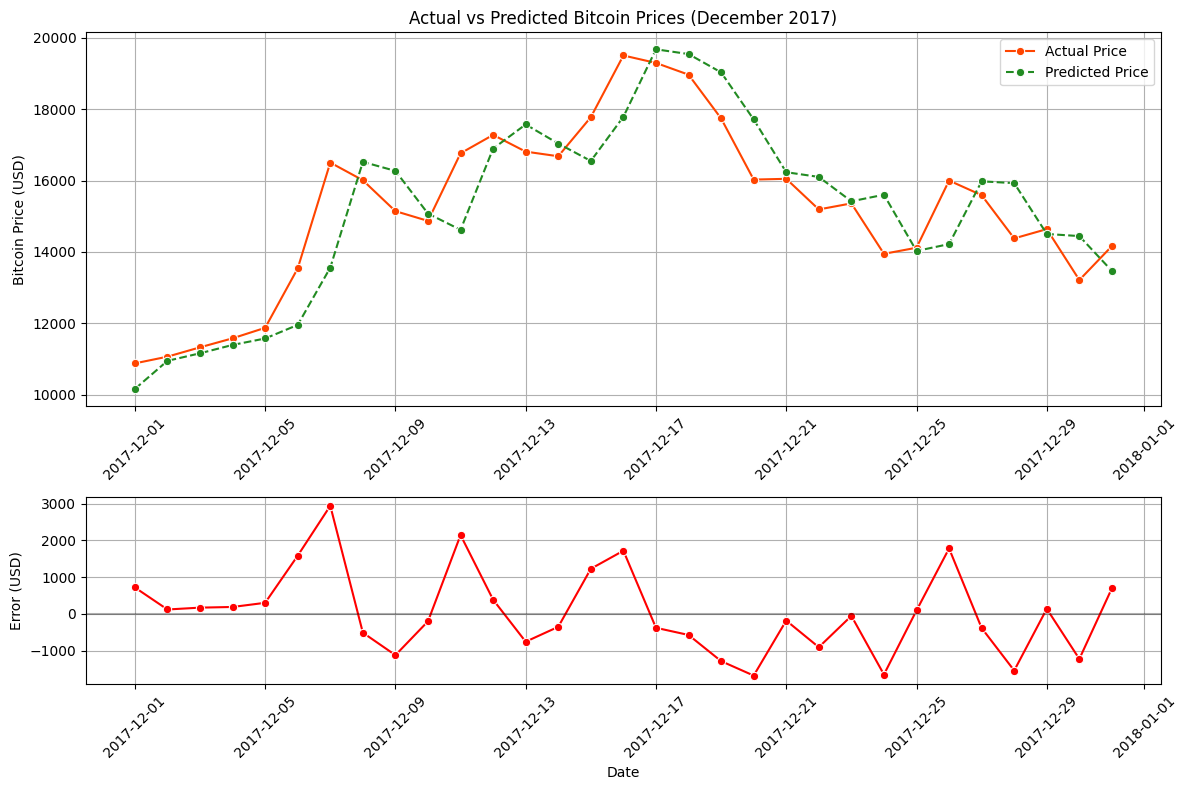

In [456]:
print(f"RMSE for December 2017: {rmse:.2f}")
plot_predictions_with_error(results)
